In [25]:
from functools import partial
from time import time
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from pathlib import Path
import pprint

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from jax.typing import ArrayLike
from dataclasses import asdict
import numpy as np
import wandb
import argparse
from etils import epath
from tqdm import tqdm
import orbax.checkpoint
from etils import epath
import flax.linen as nn

from meta_transformer import utils, preprocessing, module_path, on_cluster, output_dir, interactive, data
from meta_transformer.meta_model import MetaModel, mup_adamw, MetaModelClassifier
from meta_transformer.train import Updater, Logger
from meta_transformer.data import Data, load_batches

import backdoors.utils
import backdoors.poison
from backdoors import checkpoint_dir, paths
import backdoors.train

import nnaugment
from nn_utils import schedules

rng = jax.random.PRNGKey(0)
numpy_rng = np.random.default_rng()

CLEAN_CHECKPOINT_DIR = epath.Path(checkpoint_dir) / "clean"
BACKDOOR_CHECKPOINT_DIR = epath.Path(checkpoint_dir) / "simple_pattern"
LAYERS_TO_PERM = [f"Conv_{i}" for i in range(6)]

In [33]:
DATA_DIR = '/home/lauro/projects/meta-models/neel-nninn/data/ctc_new'
net = np.load(DATA_DIR + f"/1/epoch_20.npy", allow_pickle=True).item()
print(*net.keys(), sep='\n')

ctc_net/BatchNorm_1
ctc_net/BatchNorm_11
ctc_net/BatchNorm_13
ctc_net/BatchNorm_3
ctc_net/BatchNorm_5
ctc_net/BatchNorm_7
ctc_net/BatchNorm_9
ctc_net/Conv_0
ctc_net/Conv_2
ctc_net/Conv_4
ctc_net/Conv_6
ctc_net/Conv_8
ctc_net/Dense_10
ctc_net/Dense_12
ctc_net/Dense_14


In [38]:
net["ctc_net/BatchNorm_1"]['offset'].shape

(1, 1, 1, 16)

### ctc stuff

In [29]:
filepath = "../../neel-nninn/data/ctc_fixed_10k/10/epoch_20.npy"
net = np.load(filepath, allow_pickle=True).item()
type(net)

dict

In [30]:
print(*net.keys(), sep="\n")

ctc_net/batch_norm
ctc_net/batch_norm_1
ctc_net/batch_norm_2
ctc_net/batch_norm_3
ctc_net/batch_norm_4
ctc_net/conv2_d
ctc_net/conv2_d_1
ctc_net/conv2_d_2
ctc_net/linear
ctc_net/linear_1
ctc_net/linear_2


In [31]:
net['ctc_net/batch_norm'].keys()

dict_keys(['offset', 'scale'])

In [35]:
net['ctc_net/linear_2']['w'].shape

(128, 10)

In [44]:
net['ctc_net/conv2_d_2']['w'].shape

(5, 5, 32, 32)

In [34]:
net['ctc_net/conv2_d'].keys()

dict_keys(['b', 'w'])

In [9]:
nsteps = 100
lr = 1e-3

cooldown_length = nsteps // 10
schedule = schedules.triangle_schedule(
    max_lr=lr*20,
    total_steps=nsteps//4,
    end_lr=lr,
)
schedule = schedules.add_cooldown(
    schedule, 
    cooldown_start=nsteps - cooldown_length, 
    cooldown_length=cooldown_length,
)
schedule = jax.jit(schedule)

new_schedule = schedules.constant_with_warmup_and_cooldown(
    lr, nsteps, warmup_length=nsteps//4, cooldown_start=int(nsteps*0.9), max_lr=lr*20
)

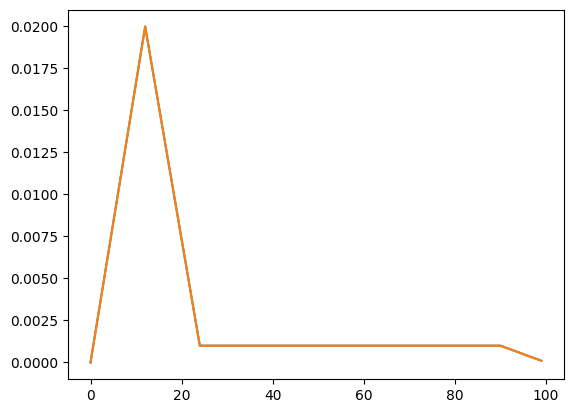

In [10]:
plt.plot([schedule(i) for i in range(nsteps)])
plt.plot([new_schedule(i) for i in range(nsteps)])

In [ ]:
loader = None

for batch in loader:
    state, val_metrics, aux = updater.compute_val_metrics(state, batch)
    metrics_logger.write(state, val_metrics, name="val")


for batch in loader:
    state, train_metrics = updater.update(state, batch)
    metrics_logger.write(state, train_metrics, name="train")

    if time() - start > args.max_runtime * 60:
        logger.info("Maximum runtime reached. Stopping training.")
        stop_training = True
        break

    if state.step > args.n_steps:
        logger.info("Maximum number of steps reached. Stopping training.")
        stop_training = True
        break

In [14]:
@jax.jit
@partial(nn_utils.schedules.add_cooldown, cooldown_start=450, cooldown_length=50)
@partial(nn_utils.schedules.add_warmup, warmup_length=50)
def schedule(step):
    return 1e-4

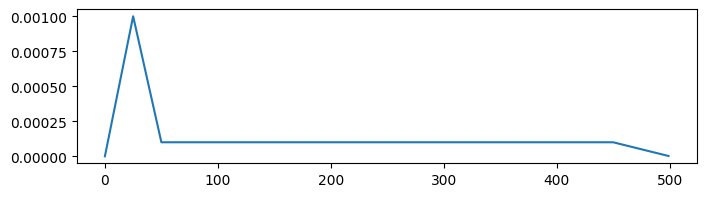

In [15]:
plt.figure(figsize=(8, 2))
xrange = np.arange(0, 500, 1)
plt.plot(xrange, [schedule(x) for x in xrange])

In [256]:
from typing import NamedTuple

In [267]:
class OptionalCooldownState(NamedTuple):
    count: int = 0
    cooldown_start: int = None
    cooldown_steps: int = 1000
    cooldown: bool = False


def optional_cooldown(lr: float):
    def init_fn(params):
        return OptionalCooldownState()
    
    def update_fn(updates, state, params=None):
        del params
        if not state.cooldown:
            return updates, state
        elif state.cooldown and state.cooldown_start is None:
            return updates, state._replace(cooldown_start=state.count)

    return optax.GradientTransformation(init_fn, update_fn)


In [244]:
@optax.inject_hyperparams
def optimizer(lr: float) -> optax.GradientTransformation:
    return optax.chain(
        optax.sgd(lr),
    )


def schedule(step):
    return step


opt = optimizer(1e-3)

In [249]:
opt_state = opt.init({"w": 0.0})
print("count:", opt_state.count)
print("hyperparams:", opt_state.hyperparams)

count: 0
hyperparams: {'lr': Array(0.001, dtype=float32, weak_type=True)}


In [255]:
updates, opt_state = opt.update({"w": np.array(1.0)}, opt_state)

print("count:", opt_state.count)
print("hyperparams:", opt_state.hyperparams)
print()
print("updates:", updates)

count: 6
hyperparams: {'lr': Array(0.001, dtype=float32)}

updates: {'w': Array(-0.001, dtype=float32)}
